In [ ]:
# Setup (run once)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [1]:
# Import libraries
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Import preprocessing method
from preprocessing import preprocess

In [3]:
# Define constants
BATCH_SIZE = 128
ENCODED_VECTOR_SIZE = 300
LSTM_SIZE = 100
MAX_WORDS = 10000
NUM_CLASSES = 20
NUM_EPOCHS = 10
OUTPUT_SIZE = 100
TEST_SIZE = 0.2
VALIDATION_SPLIT = 0.1

In [4]:
# Load datasets
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
texts = newsgroups.data
labels = newsgroups.target

In [5]:
# Preprocess texts
preprocessed_texts = [preprocess(text) for text in texts]

# Instantiate tokenizer
# tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer = Tokenizer()

# Tokenize words from samples
tokenizer.fit_on_texts(preprocessed_texts)
num_words = len(tokenizer.word_index) + 1

# Convert to vetorized sequences 
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Pad sequences to all be same size
# padded_sequences = pad_sequences(sequences)
padded_sequences = pad_sequences(sequences, maxlen=ENCODED_VECTOR_SIZE)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=TEST_SIZE, shuffle=True)

In [6]:
# Load pre-trained word embeddings
path_to_glove_file =  "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
# Embedding Matrix
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_words, ENCODED_VECTOR_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in pre-trained embeddings will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 63711 words (84568 misses)


In [8]:
# Define LSTM model
model = keras.Sequential()
model.add(Embedding(num_words, ENCODED_VECTOR_SIZE, embeddings_initializer=keras.initializers.Constant(embedding_matrix),trainable=False))
model.add(LSTM(LSTM_SIZE))
model.add(Dense(BATCH_SIZE, activation='softmax'))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         44484000  
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
Total params: 44657328 (170.35 MB)
Trainable params: 173328 (677.06 KB)
Non-trainable params: 44484000 (169.69 MB)
_________________________________________________________________
None


In [9]:
# Train the model
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALIDATION_SPLIT)

Epoch 1/10
106/106 [==============================] - 83s 778ms/step - loss: 3.1110 - accuracy: 0.1146 - val_loss: 2.6009 - val_accuracy: 0.2155
Epoch 2/10
106/106 [==============================] - 84s 797ms/step - loss: 2.2700 - accuracy: 0.3241 - val_loss: 1.9792 - val_accuracy: 0.3972
Epoch 3/10
106/106 [==============================] - 85s 796ms/step - loss: 1.7007 - accuracy: 0.4793 - val_loss: 1.5054 - val_accuracy: 0.5332
Epoch 4/10
106/106 [==============================] - 82s 772ms/step - loss: 1.3409 - accuracy: 0.5764 - val_loss: 1.3044 - val_accuracy: 0.5942
Epoch 5/10
106/106 [==============================] - 78s 739ms/step - loss: 1.1590 - accuracy: 0.6294 - val_loss: 1.1785 - val_accuracy: 0.6233
Epoch 6/10
106/106 [==============================] - 77s 723ms/step - loss: 0.9978 - accuracy: 0.6846 - val_loss: 1.0448 - val_accuracy: 0.6704
Epoch 7/10
106/106 [==============================] - 48s 448ms/step - loss: 0.8752 - accuracy: 0.7313 - val_loss: 0.9934 - val_ac

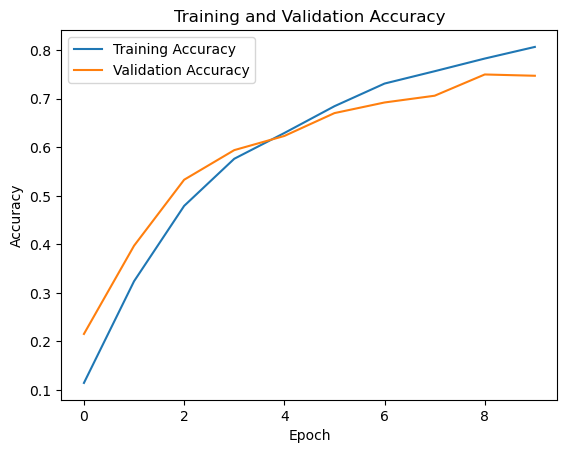

In [10]:
# Plot accuracy curves
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 7s 54ms/step
Accuracy: 0.7405835543766578


In [ ]:
# Model comparison
